In [39]:
import pandas as pd
import numpy as np

from argparse import Namespace
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import sys

sys.path.append('..')
from detectors.tf_gcp.trainer.models.models import CNNModel
from detectors.tf_gcp.trainer.data_ops.data_generator import DataGenerator

In [2]:
train_df = pd.read_csv('../sample_data/train_text.csv')
val_df = pd.read_csv('../sample_data/val_text.csv')

In [3]:
train_df.head()

,input,labels
0,don't waste your time or money!: This movie wi...,1
1,Just walk away: I expected this book to be mor...,1
2,Love mash: Mash is great but why is it a 1-4 C...,1
3,Old Rehashed NFL Films Footage.: I bought this...,1
4,"Satisfied: Good enough. It is indeed snug, and...",0


In [29]:
print(len(train_df), len(val_df))

5000 1000


In [ ]:
TOP_K = 20000
MAX_SEQUENCE_LENGTH = 500

In [7]:
tokenizer = Tokenizer(num_words=TOP_K)

In [8]:
lines = list(train_df['input']) + list(val_df['input'])

In [9]:
tokenizer.fit_on_texts(lines)

In [10]:
X_train = tokenizer.texts_to_sequences(list(train_df['input']))
X_val = tokenizer.texts_to_sequences(list(val_df['input']))

In [11]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [14]:
y_train = np.array(train_df['labels'])
y_val = np.array(val_df['labels'])

In [19]:
num_features = min(len(tokenizer.word_index) + 1, TOP_K)

In [25]:
Model = CNNModel(num_features=num_features,
                 max_sequence_length=MAX_SEQUENCE_LENGTH).build(Namespace(**{'optimizer': 'adam', 'loss': "binary_crossentropy", 'metrics': ["accuracy"],'embedding_dim': 200}))

[CNNModel::build] Building CNN model


2021-12-10 17:32:20.453740: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [26]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 200)          4000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          24704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [32]:
train_generator = DataGenerator(input_text=X_train,
                                        labels=y_train,
                                        batch_size=64)
validation_generator = DataGenerator(input_text=X_val,
                                     labels=y_val,
                                     batch_size=64)

In [34]:
history = Model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=10,
            steps_per_epoch=20,
            workers=5,
            use_multiprocessing=True)

2021-12-10 17:34:58.172763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
20/20 [==============================] - 8s 343ms/step - loss: 0.6933 - accuracy: 0.5188 - val_loss: 0.6926 - val_accuracy: 0.5130
Epoch 2/10
20/20 [==============================] - 8s 381ms/step - loss: 0.6923 - accuracy: 0.5023 - val_loss: 0.6903 - val_accuracy: 0.5130
Epoch 3/10
20/20 [==============================] - 6s 316ms/step - loss: 0.6841 - accuracy: 0.5914 - val_loss: 0.6706 - val_accuracy: 0.6750
Epoch 4/10
20/20 [==============================] - 7s 368ms/step - loss: 0.6285 - accuracy: 0.7165 - val_loss: 0.5940 - val_accuracy: 0.7380
Epoch 5/10
20/20 [==============================] - 6s 313ms/step - loss: 0.4930 - accuracy: 0.7974 - val_loss: 0.4765 - val_accuracy: 0.7660
Epoch 6/10
20/20 [==============================] - 6s 306ms/step - loss: 0.3386 - accuracy: 0.8727 - val_loss: 0.4020 - val_accuracy: 0.8230
Epoch 7/10
20/20 [==============================] - 7s 369ms/step - loss: 0.2526 - accuracy: 0.9052 - val_loss: 0.3809 - val_accuracy: 0.8460
Epoch 

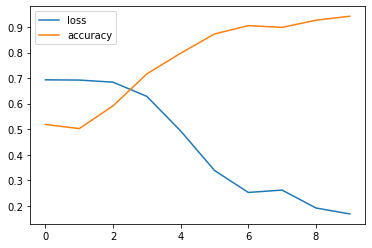

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [43]:
Model.save('./saved_model')

INFO:tensorflow:Assets written to: ./saved_model/assets
